# ConvexMPCLocomotion

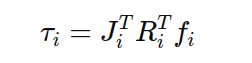

This section computes the forces 
$𝑓$ and then applies the transformation to find the desired feedforward forces `f_ff`

### 1. use get_solution to compute desired ground reaction force $f_i$
  
`f[axis]` = $f_i$

### 2. transformed from the world frame to the body frame using the rotation matrix 
  `seResult.rBody`($R^T_i$):

$$R^T_if_i$$

### 3. Storing Desired Forces
Finally, the transformed forces are stored for use in the whole-body controller (WBC):
  `Fr_des[leg] = f;`
  
  - jacobian would be in the other function

In [ ]:
for(int leg = 0; leg < 4; leg++) {
    Vec3<float> f;
    for(int axis = 0; axis < 3; axis++)
      f[axis] = get_solution(leg*3 + axis);

    f_ff[leg] = -seResult.rBody * f;
    Fr_des[leg] = f;
}

double get_solution(int index)
{
  if(!has_solved) return 0.f;
  mfp* qs = get_q_soln();
  return qs[index];
}

mfp* get_q_soln()
{
  return q_soln;
}

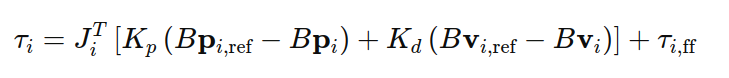

- $B_{p_{i,ref}}$ : `pDesLeg`  
- $B_{V_{i,ref}}$ : `vDesLeg`
- $B_{p_{i}}$: current foot position
- $B_{v_{i}}$: current vel
- $ \tau _{i,ff}$ : `f_ff[foot]` : feedforward torque term


### 1. Swing State Check
```cpp
for(int foot = 0; foot < 4; foot++) {
  if(swingState > 0) // foot is in swing
  {
```
### 2. Desired Position and Velocity in World Frame

```cpp
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
    Vec3<float> vDesFootWorld = footSwingTrajectories[foot].getVelocity();
```
`pDesFootWorld` and `vDesFootWorld` are the desired position and velocity of the foot in the world frame

### 3. Transforming to Body Frame
```cpp
    Vec3<float> pDesLeg = seResult.rBody * (pDesFootWorld - seResult.position) 
      - data._quadruped->getHipLocation(foot);
    Vec3<float> vDesLeg = seResult.rBody * (vDesFootWorld - seResult.vWorld);
```
- `seResult.rBody`: $R_i$
- `seResult.position`


In [7]:
for(int foot = 0; foot < 4; foot++) {
  // swing phase 체크
  if(swingState > 0) // foot is in swing
  {
    // 원하는 목표 foot pos, vel 계산 in World Frame
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
    Vec3<float> vDesFootWorld = footSwingTrajectories[foot].getVelocity();
    
    // Transforming to Body Frame
    Vec3<float> pDesLeg = seResult.rBody * (pDesFootWorld - seResult.position) 
      - data._quadruped->getHipLocation(foot);
    Vec3<float> vDesLeg = seResult.rBody * (vDesFootWorld - seResult.vWorld);

    // Update for Whole-Body Control (WBC)
    pFoot_des[foot] = pDesFootWorld; // 목표 foot pos
    vFoot_des[foot] = vDesFootWorld; // 목표 foot vel
    aFoot_des[foot] = footSwingTrajectories[foot].getAcceleration(); // 목표 foot 가속도
      
    if(!data.userParameters->use_wbc){
      data._legController->commands[foot].pDes = pDesLeg;
      data._legController->commands[foot].vDes = vDesLeg;
      data._legController->commands[foot].kpCartesian = Kp; // Kp 게인
      data._legController->commands[foot].kdCartesian = Kd; // Kd 게인
    }
  }
  else // foot is in stance
  {
    // 원하는 목표 foot pos, vel 계산 in World Frame
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
    Vec3<float> vDesFootWorld = footSwingTrajectories[foot].getVelocity();
    
    // Transforming to Body Frame
    Vec3<float> pDesLeg = seResult.rBody * (pDesFootWorld - seResult.position) - data._quadruped->getHipLocation(foot);
    Vec3<float> vDesLeg = seResult.rBody * (vDesFootWorld - seResult.vWorld);

    if(!data.userParameters->use_wbc){
      data._legController->commands[foot].pDes = pDesLeg;
      data._legController->commands[foot].vDes = vDesLeg;
      data._legController->commands[foot].kpCartesian = Kp_stance; // stance에는 다른 Kp 게인을 사용한다
      data._legController->commands[foot].kdCartesian = Kd_stance; // stance에는 다른 Kd 게인을 사용한다

      data._legController->commands[foot].forceFeedForward = f_ff[foot]; // tau_ff(feedforward force)이다
    }else{
      data._legController->commands[foot].pDes = pDesLeg;
      data._legController->commands[foot].vDes = vDesLeg;
      data._legController->commands[foot].kpCartesian = 0.*Kp_stance;
      data._legController->commands[foot].kdCartesian = Kd_stance;
    }
  }
}


input_line_13:4:6: error: use of undeclared identifier 'swingState'
  if(swingState > 0) // foot is in swing
     ^
input_line_13:7:5: error: no template named 'Vec3'
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
    ^
input_line_13:7:33: error: use of undeclared identifier 'footSwingTrajectories'
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
                                ^
input_line_13:8:17: error: use of undeclared identifier 'vDesFootWorld'; did you mean 'pDesFootWorld'?
    Vec3<float> vDesFootWorld = footSwingTrajectories[foot].getVelocity();
                ^~~~~~~~~~~~~
                pDesFootWorld
input_line_13:7:17: note: 'pDesFootWorld' declared here
    Vec3<float> pDesFootWorld = footSwingTrajectories[foot].getPosition();
                ^
input_line_13:8:16: error: expected ';' after expression
    Vec3<float> vDesFootWorld = footSwingTrajectories[foot].getVelocity();
               ^
               ;
input_line

Interpreter Error: 

# SolverMPC.cpp

### ct_ss_mats()
function computes the continuous-time state-space matrices $A$ and $B$.
- A matrix represents the state transition dynamics.
- B matrix represents the control input dynamics.


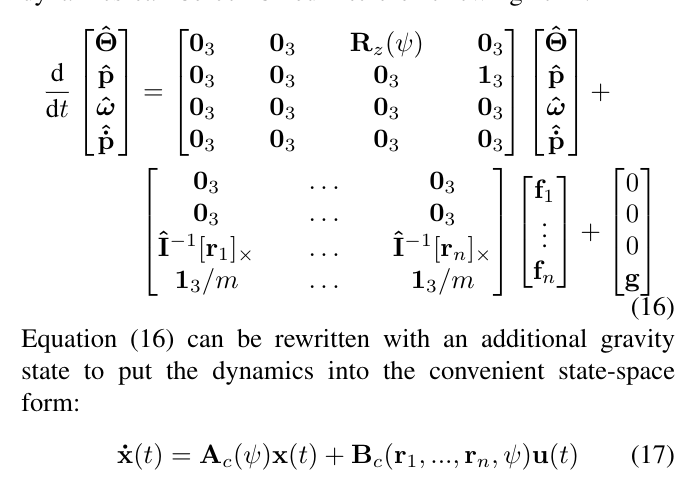
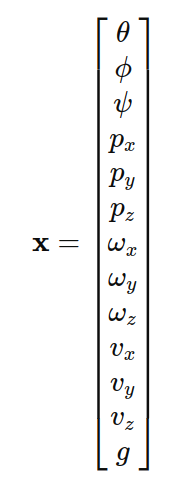

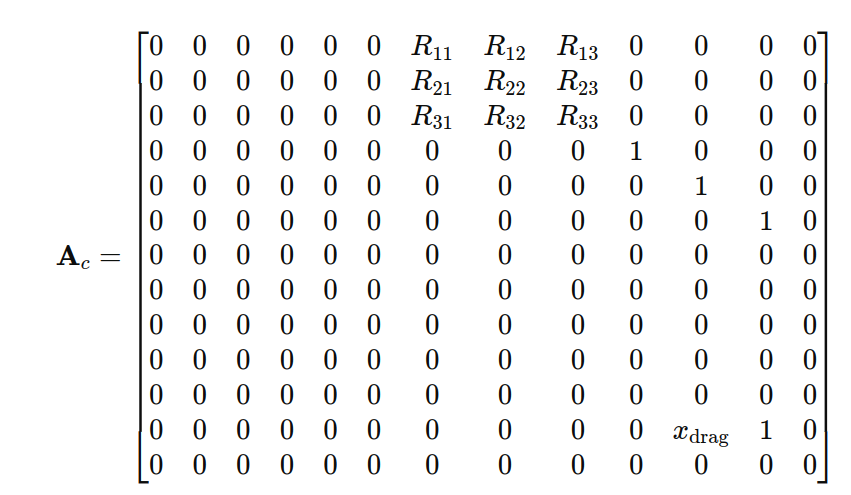
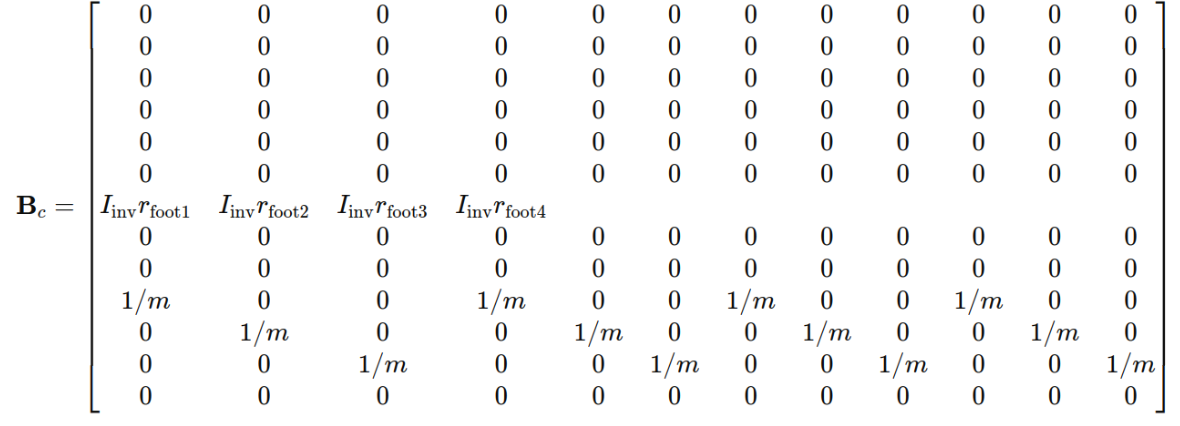

In [ ]:
void ct_ss_mats(Matrix<fpt,3,3> I_world, fpt m, Matrix<fpt,3,4> r_feet, Matrix<fpt,3,3> R_yaw, Matrix<fpt,13,13>& A, Matrix<fpt,13,12>& B, float x_drag)
{
  A.setZero();// 13 x 13 행렬이다
  A(3,9) = 1.f; // p_x, 1.f = 1.0 float
  A(4,10) = 1.f; // p_y
  A(5,11) = 1.f; // p_z
  A(11,9) = x_drag; // drag term affecting the 𝜔˙𝑥 x


  A(11,12) = 1.f; //for gravity compensation
  A.block(0,6,3,3) = R_yaw.transpose(); // R_z(\psi)T

  B.setZero();
  Matrix<fpt,3,3> I_inv = I_world.inverse();

  for(s16 b = 0; b < 4; b++)
  {
    B.block(6,b*3,3,3) = cross_mat(I_inv,r_feet.col(b));
    B.block(9,b*3,3,3) = Matrix<fpt,3,3>::Identity() / m;
  }
}


## 2. c2qp Function
continuous-time -> discrete-time for QP formulation


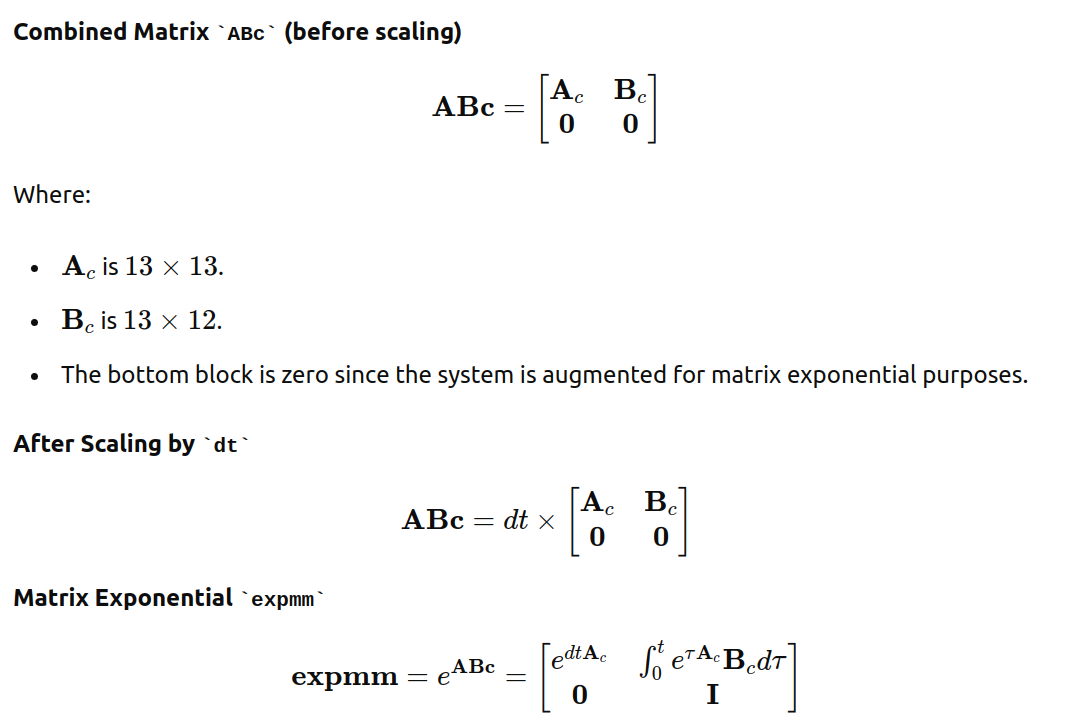
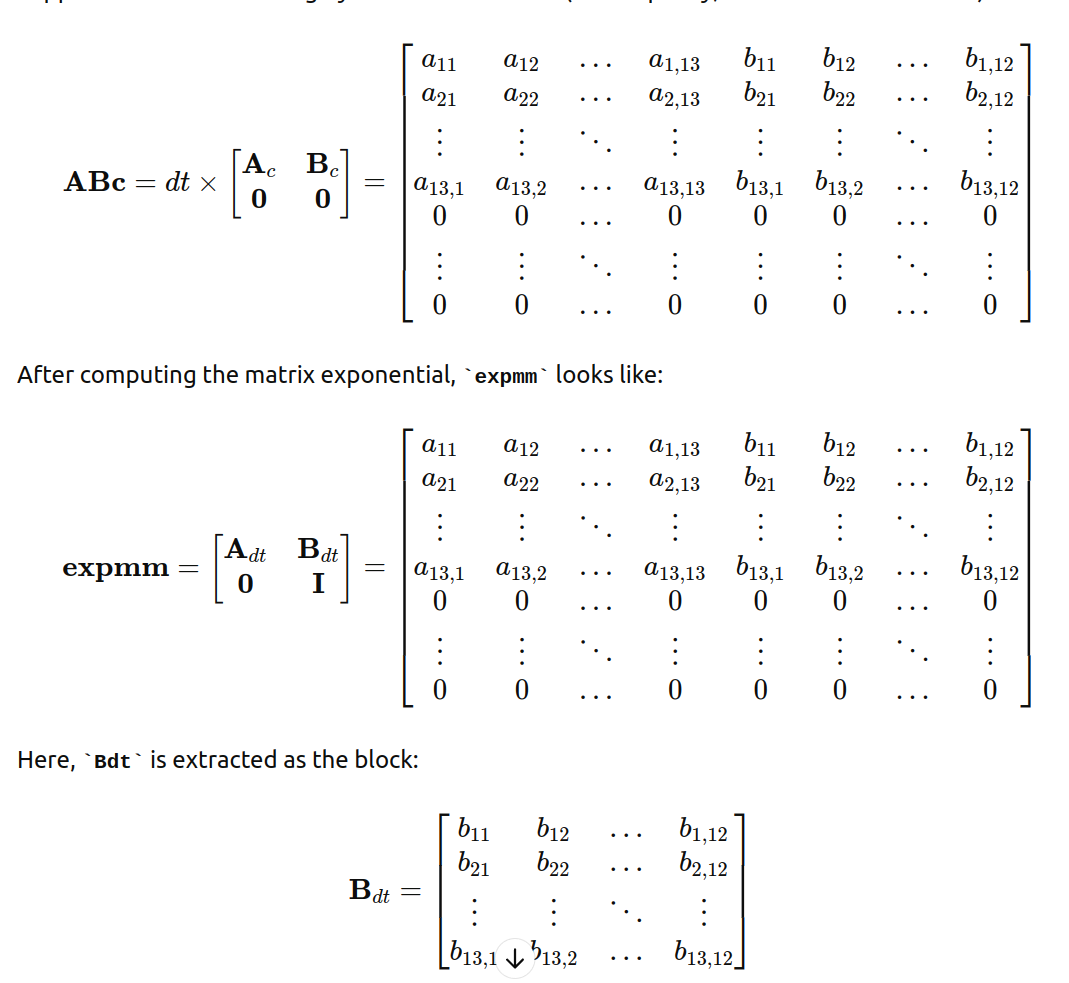

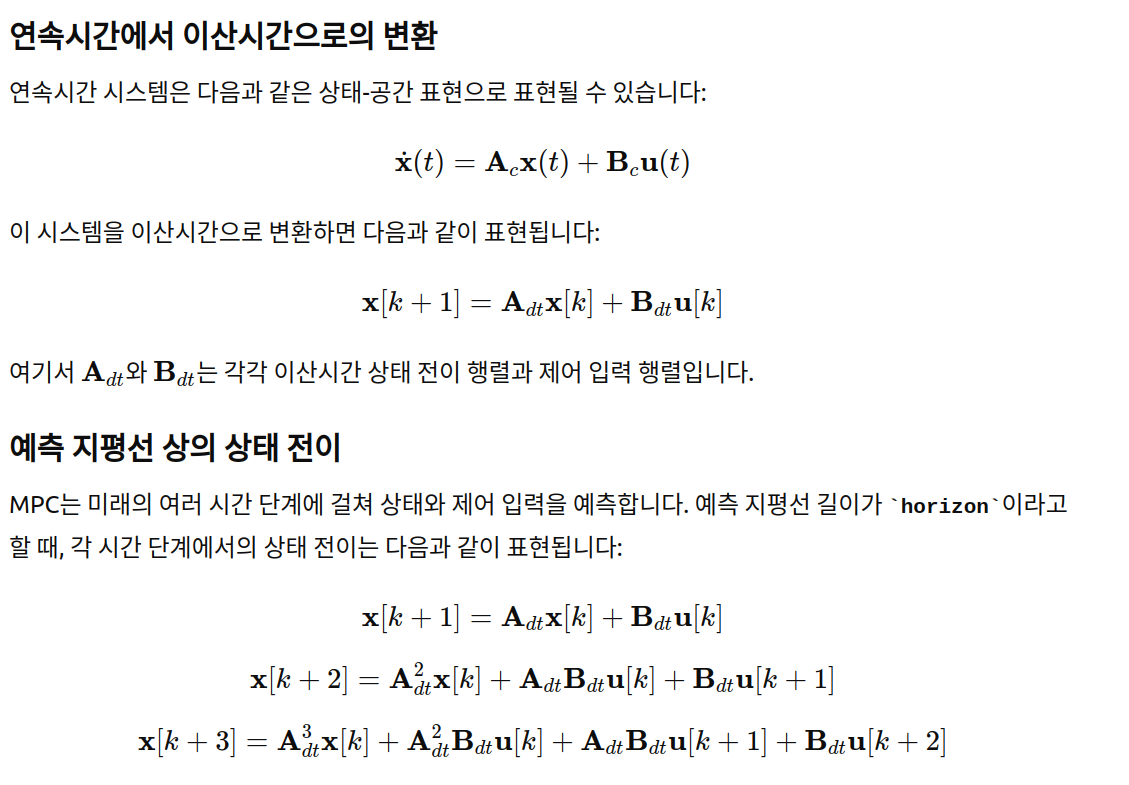
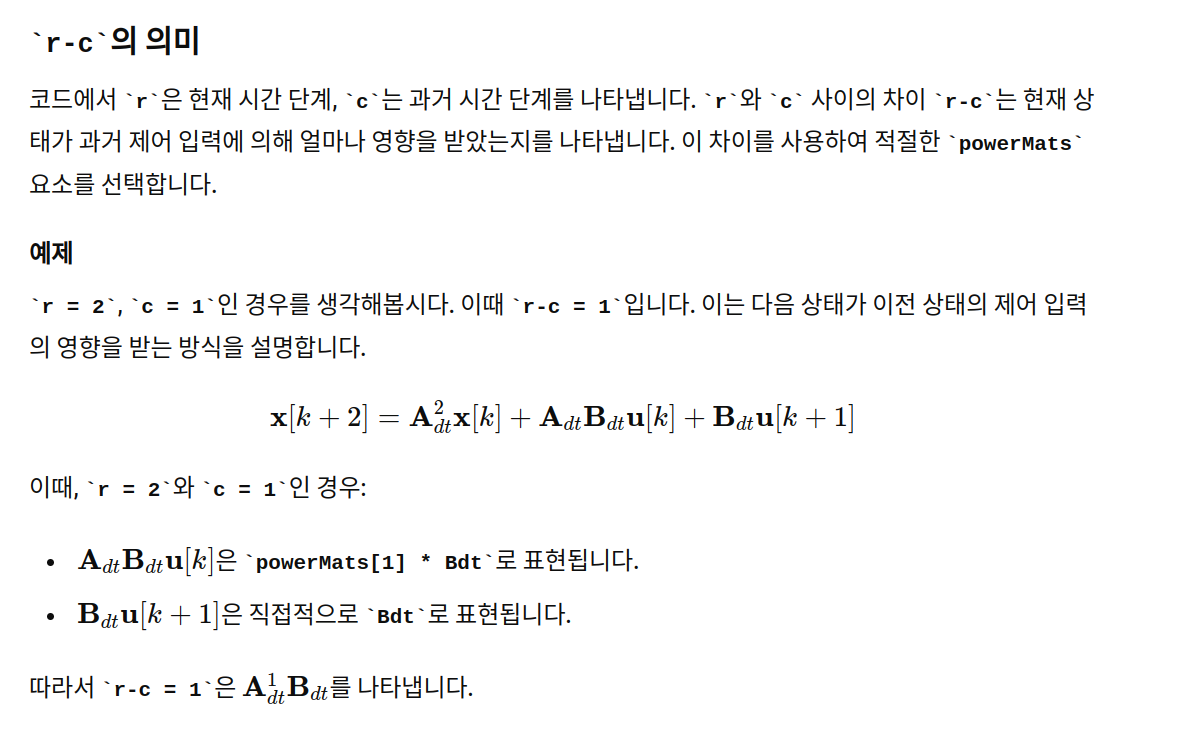

In [ ]:
void c2qp(Matrix<fpt,13,13> Ac, Matrix<fpt,13,12> Bc,fpt dt,s16 horizon)
{
  ABc.setZero();
  ABc.block(0,0,13,13) = Ac;
  ABc.block(0,13,13,12) = Bc;
  ABc = dt*ABc;
  expmm = ABc.exp(); //  25×25이다 Computes the matrix exponential of ABc.
  Adt = expmm.block(0,0,13,13); // 0,0부터 13,13까지의 블록을 Adt에 넣는다
  Bdt = expmm.block(0,13,13,12); //

  if(horizon > 19) {
    throw std::runtime_error("horizon is too long!");
  }

  Matrix<fpt,13,13> powerMats[20];
  powerMats[0].setIdentity();
  
  // horizon(예측 지평선)까지 반복하는 루프를 시작
  for(int i = 1; i < horizon+1; i++) {
    powerMats[i] = Adt * powerMats[i-1]; // 인덱스의 값에 Adt를 곱한 값을 powerMats[i]에 넣는다, adt, adt^2, adt^3, ... adt^horizon
  }

  for(s16 r = 0; r < horizon; r++) // r: 현재
  {
    A_qp.block(13*r,0,13,13) = powerMats[r+1];
    for(s16 c = 0; c < horizon; c++) // c: 이전
    {
      if(r >= c)
      {
        s16 a_num = r-c;
        B_qp.block(13*r,12*c,13,12) = powerMats[a_num] * Bdt;
      }
    }
  }
}


## 3. solve_mpc
- This function sets up and solves the MPC problem using the QP solver.
- Related Equations:
- The MPC optimization problem formulation and solution process

In [ ]:
void solve_mpc(update_data_t* update, problem_setup* setup)
{
  rs.set(update->p, update->v, update->q, update->w, update->r, update->yaw);
  Matrix<fpt,3,1> rpy;
  quat_to_rpy(rs.q,rpy);

  x_0 << rpy(2), rpy(1), rpy(0), rs.p , rs.w, rs.v, -9.8f;
  I_world = rs.R_yaw * rs.I_body * rs.R_yaw.transpose();
  ct_ss_mats(I_world,rs.m,rs.r_feet,rs.R_yaw,A_ct,B_ct_r, update->x_drag);

  c2qp(A_ct,B_ct_r,setup->dt,setup->horizon);

  Matrix<fpt,13,1> full_weight;
  for(u8 i = 0; i < 12; i++)
    full_weight(i) = update->weights[i];
  full_weight(12) = 0.f;
  S.diagonal() = full_weight.replicate(setup->horizon,1);

  for(s16 i = 0; i < setup->horizon; i++)
  {
    for(s16 j = 0; j < 12; j++)
      X_d(13*i+j,0) = update->traj[12*i+j];
  }

  s16 k = 0;
  for(s16 i = 0; i < setup->horizon; i++)
  {
    for(s16 j = 0; j < 4; j++)
    {
      U_b(5*k + 0) = BIG_NUMBER;
      U_b(5*k + 1) = BIG_NUMBER;
      U_b(5*k + 2) = BIG_NUMBER;
      U_b(5*k + 3) = BIG_NUMBER;
      U_b(5*k + 4) = update->gait[i*4 + j] * setup->f_max;
      k++;
    }
  }

  fpt mu = 1.f/setup->mu;
  Matrix<fpt,5,3> f_block;

  f_block <<  mu, 0,  1.f,
    -mu, 0,  1.f,
    0,  mu, 1.f,
    0, -mu, 1.f,
    0,   0, 1.f;

  for(s16 i = 0; i < setup->horizon*4; i++)
  {
    fmat.block(i*5,i*3,5,3) = f_block;
  }

  qH = 2*(B_qp.transpose()*S*B_qp + update->alpha*eye_12h);
  qg = 2*B_qp.transpose()*S*(A_qp*x_0 - X_d);

  QpProblem<double> jcqp(setup->horizon*12, setup->horizon*20);
  if(update->use_jcqp == 1) {
    jcqp.A = fmat.cast<double>();
    jcqp.P = qH.cast<double>();
    jcqp.q = qg.cast<double>();
    jcqp.u = U_b.cast<double>();
    for(s16 i = 0; i < 20*setup->horizon; i++)
      jcqp.l[i] = 0.;

    jcqp.settings.sigma = update->sigma;
    jcqp.settings.alpha = update->solver_alpha;
    jcqp.settings.terminate = update->terminate;
    jcqp.settings.rho = update->rho;
    jcqp.settings.maxIterations = update->max_iterations;
    jcqp.runFromDense(update->max_iterations, true, false);
  } else {

    matrix_to_real(H_qpoases,qH,setup->horizon*12, setup->horizon*12);
    matrix_to_real(g_qpoases,qg,setup->horizon*12, 1);
    matrix_to_real(A_qpoases,fmat,setup->horizon*20, setup->horizon*12);
    matrix_to_real(ub_qpoases,U_b,setup->horizon*20, 1);

    for(s16 i = 0; i < 20*setup->horizon; i++)
      lb_qpoases[i] = 0.0f;

    s16 num_constraints = 20*setup->horizon;
    s16 num_variables = 12*setup->horizon;

    qpOASES::int_t nWSR = 100;

    int new_vars = num_variables;
    int new_cons = num_constraints;

    for(int i =0; i < num_constraints; i++)
      con_elim[i] = 0;

    for(int i = 0; i < num_variables; i++)
      var_elim[i] = 0;

    for(int i = 0; i < num_constraints; i++)
    {
      if(! (near_zero(lb_qpoases[i]) && near_zero(ub_qpoases[i]))) continue;
      double* c_row = &A_qpoases[i*num_variables];
      for(int j = 0
